In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time
from sklearn.model_selection import train_test_split
path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"

#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")


Using device: cuda


## Data set import

In [2]:
class loaded:
    def __init__(self,t=20,filename="X_data_15.npz"):
        data = np.load(datapath+filename) #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+filename.replace("X","y")) #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

    def resize(self,percentage):
        h=int(self.X.shape[2]*percentage)
        w=int(self.X.shape[3]*percentage)
        new_array=np.zeros((*self.X.shape[0:2],h,w))

        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                iamge = cv2.resize(image,(w,h),interpolation=cv2.INTER_AREA)
                new_array[i][j]=iamge
        self.X=new_array.copy()
#data=loaded(t=13)
#data.applySobel()
#data.augment()

Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
(2600, 4, 110, 120)


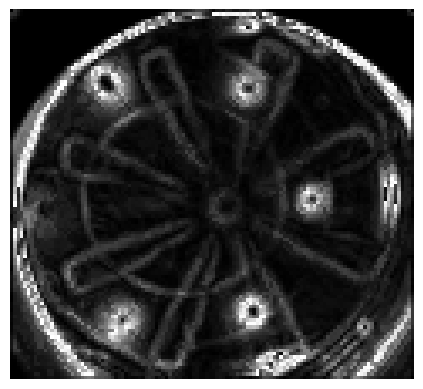

In [6]:
data=loaded(4)
data.applySobel()
print(data.X.shape)
plt.imshow(data.X[0][0],cmap="gray")
plt.axis("off")
plt.savefig(path+"/images/newMorphProcessed.pdf")
plt.show()

### gen data

In [4]:
def genData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    data.applySobel()
    """data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data3=loaded(to,filename="X_data_gel_15.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data2.X,data3.X])
    data.y=np.concatenate([data.y,data2.y,data3.y])
    del data2
    del data3"""
    data.resize(percentage)
    data.augment()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_data_newMorph.npz")
    #d.applySobel()
    #p20=d.X[np.where(d.y==3)]
    #data.X=np.concatenate([data.X,p20])
    #data.y=np.concatenate([data.y,np.zeros((len(p20)))+11])

    #data.augment()
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to)*data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique

def gen3DData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(frm=frm,t=to)
    data.applySobel()
    data.augment()
    data.resize(percentage)
    n=int(len(data.X)*0.6)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique
def genLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    data.applySobel()
    data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data3=loaded(to,filename="X_data_gel_15.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data2.X,data3.X])
    data.y=np.concatenate([data.y,data2.y,data3.y])
    del data2
    del data3
    data.augment()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
    #d.applySobel()
    #data.augment()
    #data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),abs(frm-to),data.X.shape[2]*data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique
def genCNNLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    data.applySobel()
    data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data3=loaded(to,filename="X_data_gel_15.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data2.X,data3.X])
    data.y=np.concatenate([data.y,data2.y,data3.y])
    del data2
    del data3
    data.augment()

    #data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique

## Model

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self,input_height, input_width,output=15):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten_size = 10 * (input_height // 4) * (input_width // 4)
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Simple3DCNN(nn.Module):
    def __init__(self, input_depth, input_height, input_width):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
        depth = input_depth
        height = input_height
        width = input_width
        
        depth = depth // 2  # after first pooling
        height = height // 2
        width = width // 2
        
        depth = depth // 2  # after second pooling
        height = height // 2
        width = width // 2
        
        # Number of output features from conv layers (channels * depth * height * width)
        self.flatten_size = 10 * depth * height * width
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 13)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class CNN_LSTM(nn.Module):
    def __init__(self, input_width, input_height, hidden_size, num_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # Define the CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        )
        
        # Calculate the CNN output size
        cnn_output_size = self._get_cnn_output_size(input_width, input_height)
        
        # Define the LSTM part
        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define the final fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def _get_cnn_output_size(self, width, height):
        # Create a dummy tensor with the given width and height
        dummy_input = torch.zeros(1, 1, height, width)
        
        # Pass the dummy tensor through the CNN
        dummy_output = self.cnn(dummy_input)
        
        # Calculate the output size by flattening the output
        return dummy_output.view(-1).size(0)
    
    def forward(self, x):
        batch_size, c, sequence_length, h, w = x.size()
        # Reshape input to (batch_size * sequence_length, c, h, w) for CNN
        c_in = x.view(batch_size * sequence_length, c, h, w)
        
        # Pass through CNN
        c_out = self.cnn(c_in)
        
        # Flatten the CNN output
        c_out = c_out.view(c_out.size(0), -1)
        
        # Reshape to (batch_size, sequence_length, cnn_output_size) for LSTM
        lstm_in = c_out.view(batch_size, sequence_length, -1)
        
        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(lstm_in)
        
        # Get the output from the last time step
        output = lstm_out[:, -1, :]
        
        # Pass through fully connected layer
        output = self.fc(output)
        
        return output
    


## Train

In [6]:
# Define the Loss Function and Optimizer
def run(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleCNN(image.shape[0],image.shape[1],output=output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def run3D(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    model = Simple3DCNN(image.shape[0],image.shape[1],image.shape[2]).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def calc(model,data_loader):
        correct=0
        summed=0.1
        for i, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)
            a=torch.argmax(outputs,axis=1)==torch.argmax(labels,axis=1)

            summed+=len(inputs)
            correct+=len(a[a==1])
        print("Accuracy:",(correct/summed)*100,"%")
        return correct/summed
def runLSTM(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleLSTM(image.shape[0],1000,output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def runLSTMcnn(train_loader,frm,to,num_epochs=150):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = CNN_LSTM(image.shape[1],image.shape[0],1000,1,output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

### CNN train

In [7]:
torch.cuda.empty_cache()
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/uber_model") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 25800 
Window size: 4 
Image: (110, 120)
Memory needed: 1.27 GB
Memory left 12.0 GB
Using 7.1 GB
torch.Size([18060, 1, 440, 120])
torch.Size([18060, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_13128\4119234653.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [362/362], Loss: 968.7405
Epoch [11/100], Step [362/362], Loss: 133.0803
Epoch [21/100], Step [362/362], Loss: 54.1684
Epoch [31/100], Step [362/362], Loss: 28.1525
Epoch [41/100], Step [362/362], Loss: 16.3266
Epoch [51/100], Step [362/362], Loss: 12.5999
Epoch [61/100], Step [362/362], Loss: 8.2883
Epoch [71/100], Step [362/362], Loss: 5.9203
Epoch [81/100], Step [362/362], Loss: 4.4190
Epoch [91/100], Step [362/362], Loss: 4.5889
Finished Training
Accuracy: 99.77575371667452 %
0.9977575371667451
Accuracy: 99.88164533744921 %
0.9988164533744921


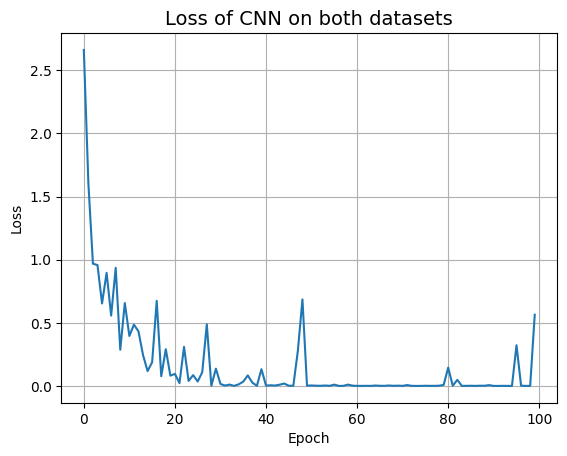

In [8]:
plt.plot(history)
plt.grid(True)
plt.title("Loss of CNN on both datasets",fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path+"/images/loss_of_uber_model.pdf")
plt.show()

In [48]:
train_loader,test_loader,unique=genData(0,4)
data=loaded(4,filename="X_data_newMorph.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=13).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))
model.eval()

Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (110, 120)
Memory needed: 0.38 GB
Memory left 1.93 GB
Using 2.15 GB
torch.Size([5460, 1, 440, 120])
torch.Size([5460, 13])


/tmp/ipykernel_21459/1734164554.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
  (relu): ReLU()
)

In [42]:


ar=[]
acc=[]
for i in range(5):
    try:
        torch.cuda.empty_cache()
        train_loader,test_loader,unique=genData(0,4)
        model,history=run(train_loader,0,4)
        ar.append(history)
        print(calc(model,test_loader))
        print(calc(model,train_loader))
        acc.append(calc(model,test_loader))
        if acc[-1]>=max(acc):
            torch.save(model.state_dict(), path+"/model/mymmodel_") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
    except MemoryError as e:
        try:
            del train_loader
            del test_loader
            del model
        except: 
            pass
ar=np.array(ar)
acc=np.array(acc)


np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/accuracies_of_NM",acc)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/loss_of_NM",ar)

Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 800 
Window size: 20 
Image: (110, 120)
Memory needed: 0.2 GB
Dataset size: 8400 
Window size: 4 
Image: (110, 120)
Memory needed: 0.41 GB
Memory left 1.93 GB
Using 2.31 GB
torch.Size([5880, 1, 440, 120])
torch.Size([5880, 13])


/tmp/ipykernel_27645/2749350419.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [118/118], Loss: 299.0478
Epoch [11/100], Step [118/118], Loss: 93.6923
Epoch [21/100], Step [118/118], Loss: 47.2235
Epoch [31/100], Step [118/118], Loss: 32.5718
Epoch [41/100], Step [118/118], Loss: 24.7363
Epoch [51/100], Step [118/118], Loss: 20.1131
Epoch [61/100], Step [118/118], Loss: 15.7617
Epoch [71/100], Step [118/118], Loss: 13.0306
Epoch [81/100], Step [118/118], Loss: 11.2857
Epoch [91/100], Step [118/118], Loss: 10.0537
Finished Training
Accuracy: 98.29096165292069 %
0.9829096165292068
Accuracy: 98.91371356901426 %
0.9891371356901426
Accuracy: 98.29096165292069 %


In [28]:
test_scores=np.zeros((10,14,3))
train_scores=np.zeros((10,14,3))
t_averages=np.zeros((10*14*3))

#test_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/test_scores.npy")
#train_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/train_scores.npy")
c=0
for i in range(1,10): #loop through frm dimention
    for j in range(i+1,15): #loop though to dimention
        print(">>>>",i,j,"\nMax:",np.max(test_scores)*100,"%","\nEstimated time left:",(np.average(t_averages[t_averages!=0])*len(t_averages[t_averages==0]))/60,"minutes")
        for trial in range(3):
            t=time.time()
            torch.cuda.empty_cache()
            train_loader,test_loader,__=genData(i,j)
            model=run(train_loader,i,j)
            test_scores[i][j-1][trial]=calc(model,test_loader)
            train_scores[i][j-1][trial]=calc(model,train_loader)
            torch.cuda.empty_cache()
            del train_loader
            del test_loader
            del model
            t2=time.time()
            t_averages[c]=t2-t
            c+=1
        clear_output(wait=True)
        np.save(path+"saves/test_scores_NM",test_scores)
        np.save(path+"saves/train_scores_NM",train_scores)




/its/home/drs25/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/its/home/drs25/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


>>>> 1 2 
Max: 0.0 % 
Estimated time left: nan minutes
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 2 
Image: (110, 120)
Memory needed: 0.19 GB
Memory left 1.93 GB


ValueError: cannot reshape array of size 144144000 into shape (5460,1,110,120)

#### resolution

In [8]:

resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
scores_test=np.zeros((len(resolutions),3))
scores_train=np.zeros((len(resolutions),3))
for i, res in enumerate(resolutions):
    print("Testing resolution",res)
    for j in range(3): #three trials on each
        torch.cuda.empty_cache()
        train_loader,test_loader,unique=genData(0,4,res)
        model,history=run(train_loader,0,4,num_epochs = 100)
        test_acc=calc(model,test_loader)
        train_acc=calc(model,train_loader)
        scores_test[i][j]=test_acc
        scores_train[i][j]=train_acc
        print("\t\t",test_acc*100,"%",train_acc*100,"%")
        del train_loader
        del test_loader
        del model
np.save(path+"/data/test_resolutions_NM",scores_test)
np.save(path+"/data/train_resolutions_NM",scores_train)


Testing resolution 0.05
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (5, 6)
Memory needed: 0.0 GB
Memory left 12.0 GB
Using 0.0 GB
torch.Size([5460, 1, 20, 6])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.3623
Epoch [11/100], Step [110/110], Loss: 282.0813
Epoch [21/100], Step [110/110], Loss: 281.9760
Epoch [31/100], Step [110/110], Loss: 281.8777
Epoch [41/100], Step [110/110], Loss: 281.7638
Epoch [51/100], Step [110/110], Loss: 281.6018
Epoch [61/100], Step [110/110], Loss: 281.3296
Epoch [71/100], Step [110/110], Loss: 280.8793
Epoch [81/100], Step [110/110], Loss: 280.0399
Epoch [91/100], Step [110/110], Loss: 278.1504
Finished Training
Accuracy: 20.23624210237158 %
Accuracy: 21.86305258579245 %
		 20.23624210237158 % 21.86305258579245 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (5, 6)
Memory needed: 0.0 GB
Memory left 12.0 GB
Using 0.0 GB
torch.Size([5460, 1, 20, 6])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.3162
Epoch [11/100], Step [110/110], Loss: 282.0314
Epoch [21/100], Step [110/110], Loss: 281.9035
Epoch [31/100], Step [110/110], Loss: 281.8223
Epoch [41/100], Step [110/110], Loss: 281.6803
Epoch [51/100], Step [110/110], Loss: 281.5115
Epoch [61/100], Step [110/110], Loss: 281.2165
Epoch [71/100], Step [110/110], Loss: 280.7314
Epoch [81/100], Step [110/110], Loss: 279.7692
Epoch [91/100], Step [110/110], Loss: 277.7977
Finished Training
Accuracy: 15.29163995971065 %
Accuracy: 17.307296078386482 %
		 15.29163995971065 % 17.307296078386482 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (5, 6)
Memory needed: 0.0 GB
Memory left 12.0 GB
Using 0.0 GB
torch.Size([5460, 1, 20, 6])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2142
Epoch [11/100], Step [110/110], Loss: 282.0301
Epoch [21/100], Step [110/110], Loss: 281.9448
Epoch [31/100], Step [110/110], Loss: 281.8435
Epoch [41/100], Step [110/110], Loss: 281.6945
Epoch [51/100], Step [110/110], Loss: 281.4674
Epoch [61/100], Step [110/110], Loss: 281.0342
Epoch [71/100], Step [110/110], Loss: 280.1738
Epoch [81/100], Step [110/110], Loss: 278.3045
Epoch [91/100], Step [110/110], Loss: 272.8613
Finished Training
Accuracy: 18.95430821353356 %
Accuracy: 18.86403699549003 %
		 18.95430821353356 % 18.86403699549003 %
Testing resolution 0.1
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (11, 12)
Memory needed: 0.0 GB
Memory left 12.0 GB
Using 0.02 GB
torch.Size([5460, 1, 44, 12])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.3066
Epoch [11/100], Step [110/110], Loss: 282.0200
Epoch [21/100], Step [110/110], Loss: 281.9008
Epoch [31/100], Step [110/110], Loss: 281.7791
Epoch [41/100], Step [110/110], Loss: 281.6637
Epoch [51/100], Step [110/110], Loss: 281.5028
Epoch [61/100], Step [110/110], Loss: 281.2134
Epoch [71/100], Step [110/110], Loss: 280.7907
Epoch [81/100], Step [110/110], Loss: 280.0441
Epoch [91/100], Step [110/110], Loss: 278.2278
Finished Training
Accuracy: 18.95430821353356 %
Accuracy: 21.26782811748815 %
		 18.95430821353356 % 21.26782811748815 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (11, 12)
Memory needed: 0.0 GB
Memory left 12.0 GB
Using 0.02 GB
torch.Size([5460, 1, 44, 12])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2028
Epoch [11/100], Step [110/110], Loss: 281.9992
Epoch [21/100], Step [110/110], Loss: 281.9057
Epoch [31/100], Step [110/110], Loss: 281.8007
Epoch [41/100], Step [110/110], Loss: 281.6675
Epoch [51/100], Step [110/110], Loss: 281.4914
Epoch [61/100], Step [110/110], Loss: 281.2190
Epoch [71/100], Step [110/110], Loss: 280.7751
Epoch [81/100], Step [110/110], Loss: 279.8896
Epoch [91/100], Step [110/110], Loss: 277.9317
Finished Training
Accuracy: 16.756707261239814 %
Accuracy: 17.60490831253863 %
		 16.756707261239814 % 17.60490831253863 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (11, 12)
Memory needed: 0.0 GB
Memory left 12.0 GB
Using 0.02 GB
torch.Size([5460, 1, 44, 12])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.3843
Epoch [11/100], Step [110/110], Loss: 282.1435
Epoch [21/100], Step [110/110], Loss: 282.0227
Epoch [31/100], Step [110/110], Loss: 281.9783
Epoch [41/100], Step [110/110], Loss: 281.9112
Epoch [51/100], Step [110/110], Loss: 281.8845
Epoch [61/100], Step [110/110], Loss: 281.8258
Epoch [71/100], Step [110/110], Loss: 281.7796
Epoch [81/100], Step [110/110], Loss: 281.6758
Epoch [91/100], Step [110/110], Loss: 281.5773
Finished Training
Accuracy: 14.742239721637215 %
Accuracy: 14.674572468579013 %
		 14.742239721637215 % 14.674572468579013 %
Testing resolution 0.15
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (16, 18)
Memory needed: 0.01 GB
Memory left 12.0 GB
Using 0.05 GB
torch.Size([5460, 1, 64, 18])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.3058
Epoch [11/100], Step [110/110], Loss: 282.1058
Epoch [21/100], Step [110/110], Loss: 282.0144
Epoch [31/100], Step [110/110], Loss: 281.9433
Epoch [41/100], Step [110/110], Loss: 281.8852
Epoch [51/100], Step [110/110], Loss: 281.7659
Epoch [61/100], Step [110/110], Loss: 281.6416
Epoch [71/100], Step [110/110], Loss: 281.2753
Epoch [81/100], Step [110/110], Loss: 280.4974
Epoch [91/100], Step [110/110], Loss: 277.7111
Finished Training
Accuracy: 19.59527515795257 %
Accuracy: 19.619514205260867 %
		 19.59527515795257 % 19.619514205260867 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (16, 18)
Memory needed: 0.01 GB
Memory left 12.0 GB
Using 0.05 GB
torch.Size([5460, 1, 64, 18])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.3911
Epoch [11/100], Step [110/110], Loss: 282.1085
Epoch [21/100], Step [110/110], Loss: 281.9561
Epoch [31/100], Step [110/110], Loss: 281.8554
Epoch [41/100], Step [110/110], Loss: 281.7416
Epoch [51/100], Step [110/110], Loss: 281.5715
Epoch [61/100], Step [110/110], Loss: 281.3057
Epoch [71/100], Step [110/110], Loss: 280.8462
Epoch [81/100], Step [110/110], Loss: 279.8416
Epoch [91/100], Step [110/110], Loss: 277.0264
Finished Training
Accuracy: 18.496474681805697 %
Accuracy: 21.016002380897874 %
		 18.496474681805697 % 21.016002380897874 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (16, 18)
Memory needed: 0.01 GB
Memory left 12.0 GB
Using 0.05 GB
torch.Size([5460, 1, 64, 18])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2257
Epoch [11/100], Step [110/110], Loss: 281.9751
Epoch [21/100], Step [110/110], Loss: 281.7642
Epoch [31/100], Step [110/110], Loss: 281.4373
Epoch [41/100], Step [110/110], Loss: 280.7401
Epoch [51/100], Step [110/110], Loss: 278.7036
Epoch [61/100], Step [110/110], Loss: 268.3947
Epoch [71/100], Step [110/110], Loss: 211.5921
Epoch [81/100], Step [110/110], Loss: 149.9089
Epoch [91/100], Step [110/110], Loss: 113.8731
Finished Training
Accuracy: 58.69425876751214 %
Accuracy: 61.12497424509512 %
		 58.69425876751214 % 61.12497424509512 %
Testing resolution 0.2
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (22, 24)
Memory needed: 0.02 GB
Memory left 12.0 GB
Using 0.09 GB
torch.Size([5460, 1, 88, 24])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2932
Epoch [11/100], Step [110/110], Loss: 281.9626
Epoch [21/100], Step [110/110], Loss: 281.6921
Epoch [31/100], Step [110/110], Loss: 281.1655
Epoch [41/100], Step [110/110], Loss: 279.4892
Epoch [51/100], Step [110/110], Loss: 268.5103
Epoch [61/100], Step [110/110], Loss: 185.5003
Epoch [71/100], Step [110/110], Loss: 114.8223
Epoch [81/100], Step [110/110], Loss: 83.2980
Epoch [91/100], Step [110/110], Loss: 68.6613
Finished Training
Accuracy: 81.58593535390533 %
Accuracy: 81.31681966987935 %
		 81.58593535390533 % 81.31681966987935 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (22, 24)
Memory needed: 0.02 GB
Memory left 12.0 GB
Using 0.09 GB
torch.Size([5460, 1, 88, 24])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.3321
Epoch [11/100], Step [110/110], Loss: 281.9625
Epoch [21/100], Step [110/110], Loss: 281.7747
Epoch [31/100], Step [110/110], Loss: 281.4682
Epoch [41/100], Step [110/110], Loss: 280.9262
Epoch [51/100], Step [110/110], Loss: 279.4087
Epoch [61/100], Step [110/110], Loss: 272.1230
Epoch [71/100], Step [110/110], Loss: 211.8592
Epoch [81/100], Step [110/110], Loss: 134.0876
Epoch [91/100], Step [110/110], Loss: 93.1937
Finished Training
Accuracy: 82.86786924274334 %
Accuracy: 84.47608800164831 %
		 82.86786924274334 % 84.47608800164831 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (22, 24)
Memory needed: 0.02 GB
Memory left 12.0 GB
Using 0.09 GB
torch.Size([5460, 1, 88, 24])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1351
Epoch [11/100], Step [110/110], Loss: 281.8441
Epoch [21/100], Step [110/110], Loss: 281.5530
Epoch [31/100], Step [110/110], Loss: 281.0131
Epoch [41/100], Step [110/110], Loss: 279.5118
Epoch [51/100], Step [110/110], Loss: 271.7374
Epoch [61/100], Step [110/110], Loss: 199.0518
Epoch [71/100], Step [110/110], Loss: 121.3374
Epoch [81/100], Step [110/110], Loss: 85.3410
Epoch [91/100], Step [110/110], Loss: 67.8792
Finished Training
Accuracy: 71.69673106858346 %
Accuracy: 72.73185137702892 %
		 71.69673106858346 % 72.73185137702892 %
Testing resolution 0.25
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (27, 30)
Memory needed: 0.02 GB
Memory left 12.0 GB
Using 0.13 GB


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


torch.Size([5460, 1, 108, 30])
torch.Size([5460, 13])
Epoch [1/100], Step [110/110], Loss: 282.2753
Epoch [11/100], Step [110/110], Loss: 281.5350
Epoch [21/100], Step [110/110], Loss: 280.1993
Epoch [31/100], Step [110/110], Loss: 271.8475
Epoch [41/100], Step [110/110], Loss: 167.5097
Epoch [51/100], Step [110/110], Loss: 101.2725
Epoch [61/100], Step [110/110], Loss: 75.2673
Epoch [71/100], Step [110/110], Loss: 60.6732
Epoch [81/100], Step [110/110], Loss: 52.8828
Epoch [91/100], Step [110/110], Loss: 46.4082
Finished Training
Accuracy: 79.57146781430272 %
Accuracy: 80.49266271376571 %
		 79.57146781430272 % 80.49266271376571 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (27, 30)
Memory needed: 0.02 GB
Memory left 12.0 GB
Using 0.13 GB


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


torch.Size([5460, 1, 108, 30])
torch.Size([5460, 13])
Epoch [1/100], Step [110/110], Loss: 282.3033
Epoch [11/100], Step [110/110], Loss: 281.6058
Epoch [21/100], Step [110/110], Loss: 280.7365
Epoch [31/100], Step [110/110], Loss: 276.4798
Epoch [41/100], Step [110/110], Loss: 204.7452
Epoch [51/100], Step [110/110], Loss: 112.5910
Epoch [61/100], Step [110/110], Loss: 77.5218
Epoch [71/100], Step [110/110], Loss: 62.0362
Epoch [81/100], Step [110/110], Loss: 52.1661
Epoch [91/100], Step [110/110], Loss: 45.5628
Finished Training
Accuracy: 78.74736745719258 %
Accuracy: 79.92033149424233 %
		 78.74736745719258 % 79.92033149424233 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (27, 30)
Memory needed: 0.02 GB
Memory left 12.0 GB
Using 0.13 GB


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


torch.Size([5460, 1, 108, 30])
torch.Size([5460, 13])
Epoch [1/100], Step [110/110], Loss: 282.1719
Epoch [11/100], Step [110/110], Loss: 281.4285
Epoch [21/100], Step [110/110], Loss: 280.1146
Epoch [31/100], Step [110/110], Loss: 272.3276
Epoch [41/100], Step [110/110], Loss: 170.7856
Epoch [51/100], Step [110/110], Loss: 100.6221
Epoch [61/100], Step [110/110], Loss: 74.5675
Epoch [71/100], Step [110/110], Loss: 60.3390
Epoch [81/100], Step [110/110], Loss: 52.1942
Epoch [91/100], Step [110/110], Loss: 45.5099
Finished Training
Accuracy: 89.27753868693344 %
Accuracy: 89.9704677090726 %
		 89.27753868693344 % 89.9704677090726 %
Testing resolution 0.3
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (33, 36)
Memory needed: 0.03 GB
Memory left 12.0 GB
Using 0.19 GB
torch.Size([5460, 1, 132, 36])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2005
Epoch [11/100], Step [110/110], Loss: 281.1084
Epoch [21/100], Step [110/110], Loss: 274.2353
Epoch [31/100], Step [110/110], Loss: 151.6377
Epoch [41/100], Step [110/110], Loss: 87.6887
Epoch [51/100], Step [110/110], Loss: 62.2817
Epoch [61/100], Step [110/110], Loss: 50.3163
Epoch [71/100], Step [110/110], Loss: 42.4153
Epoch [81/100], Step [110/110], Loss: 37.4846
Epoch [91/100], Step [110/110], Loss: 33.1058
Finished Training
Accuracy: 83.41726948081678 %
Accuracy: 84.54476774799112 %
		 83.41726948081678 % 84.54476774799112 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (33, 36)
Memory needed: 0.03 GB
Memory left 12.0 GB
Using 0.19 GB
torch.Size([5460, 1, 132, 36])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2339
Epoch [11/100], Step [110/110], Loss: 281.3936
Epoch [21/100], Step [110/110], Loss: 278.7874
Epoch [31/100], Step [110/110], Loss: 218.2460
Epoch [41/100], Step [110/110], Loss: 114.1298
Epoch [51/100], Step [110/110], Loss: 80.2058
Epoch [61/100], Step [110/110], Loss: 63.1040
Epoch [71/100], Step [110/110], Loss: 51.9180
Epoch [81/100], Step [110/110], Loss: 44.8938
Epoch [91/100], Step [110/110], Loss: 40.8412
Finished Training
Accuracy: 87.72090467905869 %
Accuracy: 87.36063734804605 %
		 87.72090467905869 % 87.36063734804605 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (33, 36)
Memory needed: 0.03 GB
Memory left 12.0 GB
Using 0.19 GB
torch.Size([5460, 1, 132, 36])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1998
Epoch [11/100], Step [110/110], Loss: 281.4038
Epoch [21/100], Step [110/110], Loss: 278.2130
Epoch [31/100], Step [110/110], Loss: 201.1380
Epoch [41/100], Step [110/110], Loss: 101.3835
Epoch [51/100], Step [110/110], Loss: 68.7209
Epoch [61/100], Step [110/110], Loss: 53.3619
Epoch [71/100], Step [110/110], Loss: 43.8498
Epoch [81/100], Step [110/110], Loss: 36.5934
Epoch [91/100], Step [110/110], Loss: 31.5213
Finished Training
Accuracy: 90.1016390440436 %
Accuracy: 89.94757446029166 %
		 90.1016390440436 % 89.94757446029166 %
Testing resolution 0.35
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (38, 42)
Memory needed: 0.05 GB
Memory left 12.0 GB
Using 0.26 GB
torch.Size([5460, 1, 152, 42])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.3400
Epoch [11/100], Step [110/110], Loss: 281.2502
Epoch [21/100], Step [110/110], Loss: 276.1428
Epoch [31/100], Step [110/110], Loss: 148.8872
Epoch [41/100], Step [110/110], Loss: 83.0092
Epoch [51/100], Step [110/110], Loss: 59.8225
Epoch [61/100], Step [110/110], Loss: 47.9287
Epoch [71/100], Step [110/110], Loss: 40.4402
Epoch [81/100], Step [110/110], Loss: 36.0997
Epoch [91/100], Step [110/110], Loss: 32.4032
Finished Training
Accuracy: 82.0437688856332 %
Accuracy: 83.14827957235411 %
		 82.0437688856332 % 83.14827957235411 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (38, 42)
Memory needed: 0.05 GB
Memory left 12.0 GB
Using 0.26 GB
torch.Size([5460, 1, 152, 42])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.0938
Epoch [11/100], Step [110/110], Loss: 281.0627
Epoch [21/100], Step [110/110], Loss: 276.2735
Epoch [31/100], Step [110/110], Loss: 165.2181
Epoch [41/100], Step [110/110], Loss: 89.8434
Epoch [51/100], Step [110/110], Loss: 62.9470
Epoch [61/100], Step [110/110], Loss: 50.1118
Epoch [71/100], Step [110/110], Loss: 42.7270
Epoch [81/100], Step [110/110], Loss: 38.3726
Epoch [91/100], Step [110/110], Loss: 34.3701
Finished Training
Accuracy: 88.81970515520557 %
Accuracy: 88.73423227490213 %
		 88.81970515520557 % 88.73423227490213 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (38, 42)
Memory needed: 0.05 GB
Memory left 12.0 GB
Using 0.26 GB
torch.Size([5460, 1, 152, 42])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2279
Epoch [11/100], Step [110/110], Loss: 281.0267
Epoch [21/100], Step [110/110], Loss: 261.2863
Epoch [31/100], Step [110/110], Loss: 116.3945
Epoch [41/100], Step [110/110], Loss: 72.7692
Epoch [51/100], Step [110/110], Loss: 54.6409
Epoch [61/100], Step [110/110], Loss: 44.1195
Epoch [71/100], Step [110/110], Loss: 37.8089
Epoch [81/100], Step [110/110], Loss: 34.7370
Epoch [91/100], Step [110/110], Loss: 29.7190
Finished Training
Accuracy: 89.46067209962459 %
Accuracy: 89.03184450905427 %
		 89.46067209962459 % 89.03184450905427 %
Testing resolution 0.4
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (44, 48)
Memory needed: 0.06 GB
Memory left 12.0 GB
Using 0.34 GB
torch.Size([5460, 1, 176, 48])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2248
Epoch [11/100], Step [110/110], Loss: 280.7697
Epoch [21/100], Step [110/110], Loss: 251.3241
Epoch [31/100], Step [110/110], Loss: 105.6363
Epoch [41/100], Step [110/110], Loss: 66.3081
Epoch [51/100], Step [110/110], Loss: 49.4729
Epoch [61/100], Step [110/110], Loss: 40.4971
Epoch [71/100], Step [110/110], Loss: 34.3485
Epoch [81/100], Step [110/110], Loss: 29.9243
Epoch [91/100], Step [110/110], Loss: 25.1393
Finished Training
Accuracy: 90.55947257577147 %
Accuracy: 90.3825461871294 %
		 90.55947257577147 % 90.3825461871294 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (44, 48)
Memory needed: 0.06 GB
Memory left 12.0 GB
Using 0.34 GB
torch.Size([5460, 1, 176, 48])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2846
Epoch [11/100], Step [110/110], Loss: 280.8544
Epoch [21/100], Step [110/110], Loss: 257.2842
Epoch [31/100], Step [110/110], Loss: 109.2850
Epoch [41/100], Step [110/110], Loss: 67.9752
Epoch [51/100], Step [110/110], Loss: 52.0609
Epoch [61/100], Step [110/110], Loss: 42.3785
Epoch [71/100], Step [110/110], Loss: 36.1648
Epoch [81/100], Step [110/110], Loss: 31.5642
Epoch [91/100], Step [110/110], Loss: 28.2438
Finished Training
Accuracy: 93.7643072978665 %
Accuracy: 93.93099974817426 %
		 93.7643072978665 % 93.93099974817426 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (44, 48)
Memory needed: 0.06 GB
Memory left 12.0 GB
Using 0.34 GB
torch.Size([5460, 1, 176, 48])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1896
Epoch [11/100], Step [110/110], Loss: 278.7369
Epoch [21/100], Step [110/110], Loss: 161.9867
Epoch [31/100], Step [110/110], Loss: 82.6881
Epoch [41/100], Step [110/110], Loss: 57.2796
Epoch [51/100], Step [110/110], Loss: 44.7947
Epoch [61/100], Step [110/110], Loss: 38.0191
Epoch [71/100], Step [110/110], Loss: 32.3561
Epoch [81/100], Step [110/110], Loss: 26.9983
Epoch [91/100], Step [110/110], Loss: 25.3498
Finished Training
Accuracy: 94.31370753593994 %
Accuracy: 93.97678624573612 %
		 94.31370753593994 % 93.97678624573612 %
Testing resolution 0.45
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (49, 54)
Memory needed: 0.08 GB
Memory left 12.0 GB
Using 0.43 GB
torch.Size([5460, 1, 196, 54])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1629
Epoch [11/100], Step [110/110], Loss: 278.2859
Epoch [21/100], Step [110/110], Loss: 147.2448
Epoch [31/100], Step [110/110], Loss: 81.1892
Epoch [41/100], Step [110/110], Loss: 57.1625
Epoch [51/100], Step [110/110], Loss: 45.4758
Epoch [61/100], Step [110/110], Loss: 39.1361
Epoch [71/100], Step [110/110], Loss: 34.5591
Epoch [81/100], Step [110/110], Loss: 31.0260
Epoch [91/100], Step [110/110], Loss: 28.2537
Finished Training
Accuracy: 84.24136983792694 %
Accuracy: 82.8735605869829 %
		 84.24136983792694 % 82.8735605869829 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (49, 54)
Memory needed: 0.08 GB
Memory left 12.0 GB
Using 0.43 GB
torch.Size([5460, 1, 196, 54])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2565
Epoch [11/100], Step [110/110], Loss: 278.0704
Epoch [21/100], Step [110/110], Loss: 136.5556
Epoch [31/100], Step [110/110], Loss: 75.6424
Epoch [41/100], Step [110/110], Loss: 53.8843
Epoch [51/100], Step [110/110], Loss: 45.0121
Epoch [61/100], Step [110/110], Loss: 38.7699
Epoch [71/100], Step [110/110], Loss: 32.7450
Epoch [81/100], Step [110/110], Loss: 30.7426
Epoch [91/100], Step [110/110], Loss: 26.5724
Finished Training
Accuracy: 90.7426059884626 %
Accuracy: 89.94757446029166 %
		 90.7426059884626 % 89.94757446029166 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (49, 54)
Memory needed: 0.08 GB
Memory left 12.0 GB
Using 0.43 GB
torch.Size([5460, 1, 196, 54])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2217
Epoch [11/100], Step [110/110], Loss: 280.8364
Epoch [21/100], Step [110/110], Loss: 234.3738
Epoch [31/100], Step [110/110], Loss: 94.3397
Epoch [41/100], Step [110/110], Loss: 59.4438
Epoch [51/100], Step [110/110], Loss: 45.4612
Epoch [61/100], Step [110/110], Loss: 38.1857
Epoch [71/100], Step [110/110], Loss: 34.2553
Epoch [81/100], Step [110/110], Loss: 29.9431
Epoch [91/100], Step [110/110], Loss: 26.9279
Finished Training
Accuracy: 87.35463785367641 %
Accuracy: 88.16190105537876 %
		 87.35463785367641 % 88.16190105537876 %
Testing resolution 0.5
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (55, 60)
Memory needed: 0.1 GB
Memory left 12.0 GB
Using 0.54 GB
torch.Size([5460, 1, 220, 60])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.0770
Epoch [11/100], Step [110/110], Loss: 267.4606
Epoch [21/100], Step [110/110], Loss: 109.3896
Epoch [31/100], Step [110/110], Loss: 64.8860
Epoch [41/100], Step [110/110], Loss: 48.6594
Epoch [51/100], Step [110/110], Loss: 40.2518
Epoch [61/100], Step [110/110], Loss: 34.1779
Epoch [71/100], Step [110/110], Loss: 31.3067
Epoch [81/100], Step [110/110], Loss: 27.8431
Epoch [91/100], Step [110/110], Loss: 24.7852
Finished Training
Accuracy: 92.02453987730063 %
Accuracy: 91.82482086032829 %
		 92.02453987730063 % 91.82482086032829 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (55, 60)
Memory needed: 0.1 GB
Memory left 12.0 GB
Using 0.54 GB
torch.Size([5460, 1, 220, 60])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.3190
Epoch [11/100], Step [110/110], Loss: 280.0073
Epoch [21/100], Step [110/110], Loss: 174.9134
Epoch [31/100], Step [110/110], Loss: 85.4323
Epoch [41/100], Step [110/110], Loss: 56.2793
Epoch [51/100], Step [110/110], Loss: 44.2634
Epoch [61/100], Step [110/110], Loss: 35.9728
Epoch [71/100], Step [110/110], Loss: 31.4294
Epoch [81/100], Step [110/110], Loss: 27.8563
Epoch [91/100], Step [110/110], Loss: 25.9943
Finished Training
Accuracy: 89.00283856789673 %
Accuracy: 89.76442847004418 %
		 89.00283856789673 % 89.76442847004418 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (55, 60)
Memory needed: 0.1 GB
Memory left 12.0 GB
Using 0.54 GB
torch.Size([5460, 1, 220, 60])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.0291
Epoch [11/100], Step [110/110], Loss: 250.3252
Epoch [21/100], Step [110/110], Loss: 94.8095
Epoch [31/100], Step [110/110], Loss: 59.1207
Epoch [41/100], Step [110/110], Loss: 43.9114
Epoch [51/100], Step [110/110], Loss: 36.0326
Epoch [61/100], Step [110/110], Loss: 31.6758
Epoch [71/100], Step [110/110], Loss: 27.6000
Epoch [81/100], Step [110/110], Loss: 24.4775
Epoch [91/100], Step [110/110], Loss: 21.2398
Finished Training
Accuracy: 93.03177364710193 %
Accuracy: 93.99967949451707 %
		 93.03177364710193 % 93.99967949451707 %
Testing resolution 0.55
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (60, 66)
Memory needed: 0.12 GB
Memory left 12.0 GB
Using 0.64 GB
torch.Size([5460, 1, 240, 66])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1692
Epoch [11/100], Step [110/110], Loss: 265.9274
Epoch [21/100], Step [110/110], Loss: 102.8326
Epoch [31/100], Step [110/110], Loss: 62.2362
Epoch [41/100], Step [110/110], Loss: 46.5971
Epoch [51/100], Step [110/110], Loss: 38.9151
Epoch [61/100], Step [110/110], Loss: 33.1022
Epoch [71/100], Step [110/110], Loss: 29.8796
Epoch [81/100], Step [110/110], Loss: 27.1662
Epoch [91/100], Step [110/110], Loss: 23.6897
Finished Training
Accuracy: 93.39804047248421 %
Accuracy: 93.38156177743183 %
		 93.39804047248421 % 93.38156177743183 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (60, 66)
Memory needed: 0.12 GB
Memory left 12.0 GB
Using 0.64 GB
torch.Size([5460, 1, 240, 66])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1295
Epoch [11/100], Step [110/110], Loss: 248.0424
Epoch [21/100], Step [110/110], Loss: 94.4879
Epoch [31/100], Step [110/110], Loss: 57.6173
Epoch [41/100], Step [110/110], Loss: 43.8326
Epoch [51/100], Step [110/110], Loss: 35.4435
Epoch [61/100], Step [110/110], Loss: 31.2316
Epoch [71/100], Step [110/110], Loss: 27.4536
Epoch [81/100], Step [110/110], Loss: 24.3421
Epoch [91/100], Step [110/110], Loss: 22.5171
Finished Training
Accuracy: 94.40527424228551 %
Accuracy: 94.59490396282135 %
		 94.40527424228551 % 94.59490396282135 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (60, 66)
Memory needed: 0.12 GB
Memory left 12.0 GB
Using 0.64 GB
torch.Size([5460, 1, 240, 66])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1017
Epoch [11/100], Step [110/110], Loss: 275.3991
Epoch [21/100], Step [110/110], Loss: 116.3242
Epoch [31/100], Step [110/110], Loss: 65.9081
Epoch [41/100], Step [110/110], Loss: 48.4336
Epoch [51/100], Step [110/110], Loss: 39.2757
Epoch [61/100], Step [110/110], Loss: 34.4861
Epoch [71/100], Step [110/110], Loss: 29.0841
Epoch [81/100], Step [110/110], Loss: 26.4176
Epoch [91/100], Step [110/110], Loss: 24.8677
Finished Training
Accuracy: 80.48713487775845 %
Accuracy: 79.48535976740459 %
		 80.48713487775845 % 79.48535976740459 %
Testing resolution 0.6
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (66, 72)
Memory needed: 0.14 GB
Memory left 12.0 GB
Using 0.77 GB
torch.Size([5460, 1, 264, 72])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.2753
Epoch [11/100], Step [110/110], Loss: 279.1158
Epoch [21/100], Step [110/110], Loss: 134.8296
Epoch [31/100], Step [110/110], Loss: 67.2191
Epoch [41/100], Step [110/110], Loss: 46.9924
Epoch [51/100], Step [110/110], Loss: 37.7074
Epoch [61/100], Step [110/110], Loss: 29.5128
Epoch [71/100], Step [110/110], Loss: 25.8671
Epoch [81/100], Step [110/110], Loss: 24.2536
Epoch [91/100], Step [110/110], Loss: 21.1075
Finished Training
Accuracy: 93.48960717882979 %
Accuracy: 94.13703898720267 %
		 93.48960717882979 % 94.13703898720267 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (66, 72)
Memory needed: 0.14 GB
Memory left 12.0 GB
Using 0.77 GB
torch.Size([5460, 1, 264, 72])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1913
Epoch [11/100], Step [110/110], Loss: 280.2826
Epoch [21/100], Step [110/110], Loss: 164.1840
Epoch [31/100], Step [110/110], Loss: 75.8468
Epoch [41/100], Step [110/110], Loss: 48.5236
Epoch [51/100], Step [110/110], Loss: 38.1980
Epoch [61/100], Step [110/110], Loss: 31.5697
Epoch [71/100], Step [110/110], Loss: 27.0453
Epoch [81/100], Step [110/110], Loss: 23.5549
Epoch [91/100], Step [110/110], Loss: 21.1405
Finished Training
Accuracy: 86.25583737752955 %
Accuracy: 86.69673313339895 %
		 86.25583737752955 % 86.69673313339895 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (66, 72)
Memory needed: 0.14 GB
Memory left 12.0 GB
Using 0.77 GB
torch.Size([5460, 1, 264, 72])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1940
Epoch [11/100], Step [110/110], Loss: 269.9847
Epoch [21/100], Step [110/110], Loss: 98.3254
Epoch [31/100], Step [110/110], Loss: 57.9317
Epoch [41/100], Step [110/110], Loss: 43.4150
Epoch [51/100], Step [110/110], Loss: 35.0573
Epoch [61/100], Step [110/110], Loss: 30.1819
Epoch [71/100], Step [110/110], Loss: 25.1968
Epoch [81/100], Step [110/110], Loss: 22.7224
Epoch [91/100], Step [110/110], Loss: 19.9945
Finished Training
Accuracy: 90.19320575038917 %
Accuracy: 90.97777065543372 %
		 90.19320575038917 % 90.97777065543372 %
Testing resolution 0.7
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (77, 84)
Memory needed: 0.19 GB
Memory left 12.0 GB
Using 1.05 GB
torch.Size([5460, 1, 308, 84])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.0822
Epoch [11/100], Step [110/110], Loss: 155.0718
Epoch [21/100], Step [110/110], Loss: 71.2101
Epoch [31/100], Step [110/110], Loss: 46.5936
Epoch [41/100], Step [110/110], Loss: 36.2074
Epoch [51/100], Step [110/110], Loss: 30.0419
Epoch [61/100], Step [110/110], Loss: 24.4451
Epoch [71/100], Step [110/110], Loss: 21.7932
Epoch [81/100], Step [110/110], Loss: 20.6864
Epoch [91/100], Step [110/110], Loss: 17.8497
Finished Training
Accuracy: 97.88480908341728 %
Accuracy: 97.75417229459032 %
		 97.88480908341728 % 97.75417229459032 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (77, 84)
Memory needed: 0.19 GB
Memory left 12.0 GB
Using 1.05 GB
torch.Size([5460, 1, 308, 84])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 281.8583
Epoch [11/100], Step [110/110], Loss: 139.0679
Epoch [21/100], Step [110/110], Loss: 65.7588
Epoch [31/100], Step [110/110], Loss: 44.1609
Epoch [41/100], Step [110/110], Loss: 33.3951
Epoch [51/100], Step [110/110], Loss: 28.3856
Epoch [61/100], Step [110/110], Loss: 23.5881
Epoch [71/100], Step [110/110], Loss: 20.7283
Epoch [81/100], Step [110/110], Loss: 17.7169
Epoch [91/100], Step [110/110], Loss: 16.1241
Finished Training
Accuracy: 89.18597198058787 %
Accuracy: 89.69574872370137 %
		 89.18597198058787 % 89.69574872370137 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (77, 84)
Memory needed: 0.19 GB
Memory left 12.0 GB
Using 1.05 GB
torch.Size([5460, 1, 308, 84])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1013
Epoch [11/100], Step [110/110], Loss: 154.3063
Epoch [21/100], Step [110/110], Loss: 71.4690
Epoch [31/100], Step [110/110], Loss: 47.1477
Epoch [41/100], Step [110/110], Loss: 37.2843
Epoch [51/100], Step [110/110], Loss: 30.5920
Epoch [61/100], Step [110/110], Loss: 25.7551
Epoch [71/100], Step [110/110], Loss: 22.1418
Epoch [81/100], Step [110/110], Loss: 19.5870
Epoch [91/100], Step [110/110], Loss: 17.5384
Finished Training
Accuracy: 95.32094130574123 %
Accuracy: 95.53352716283968 %
		 95.32094130574123 % 95.53352716283968 %
Testing resolution 0.8
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (88, 96)
Memory needed: 0.25 GB
Memory left 12.0 GB
Using 1.37 GB
torch.Size([5460, 1, 352, 96])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 281.9556
Epoch [11/100], Step [110/110], Loss: 134.1587
Epoch [21/100], Step [110/110], Loss: 59.8504
Epoch [31/100], Step [110/110], Loss: 40.5768
Epoch [41/100], Step [110/110], Loss: 31.7784
Epoch [51/100], Step [110/110], Loss: 25.9828
Epoch [61/100], Step [110/110], Loss: 21.6640
Epoch [71/100], Step [110/110], Loss: 17.7406
Epoch [81/100], Step [110/110], Loss: 16.2069
Epoch [91/100], Step [110/110], Loss: 12.9268
Finished Training
Accuracy: 96.05347495650582 %
Accuracy: 96.22032462626771 %
		 96.05347495650582 % 96.22032462626771 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (88, 96)
Memory needed: 0.25 GB
Memory left 12.0 GB
Using 1.37 GB
torch.Size([5460, 1, 352, 96])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.0743
Epoch [11/100], Step [110/110], Loss: 157.4981
Epoch [21/100], Step [110/110], Loss: 67.5188
Epoch [31/100], Step [110/110], Loss: 43.9585
Epoch [41/100], Step [110/110], Loss: 33.3203
Epoch [51/100], Step [110/110], Loss: 26.0531
Epoch [61/100], Step [110/110], Loss: 20.9852
Epoch [71/100], Step [110/110], Loss: 18.5509
Epoch [81/100], Step [110/110], Loss: 16.4550
Epoch [91/100], Step [110/110], Loss: 14.7249
Finished Training
Accuracy: 88.36187162347771 %
Accuracy: 89.46681623589203 %
		 88.36187162347771 % 89.46681623589203 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (88, 96)
Memory needed: 0.25 GB
Memory left 12.0 GB
Using 1.37 GB
torch.Size([5460, 1, 352, 96])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1920
Epoch [11/100], Step [110/110], Loss: 192.7680
Epoch [21/100], Step [110/110], Loss: 68.4786
Epoch [31/100], Step [110/110], Loss: 43.0847
Epoch [41/100], Step [110/110], Loss: 32.3809
Epoch [51/100], Step [110/110], Loss: 26.1639
Epoch [61/100], Step [110/110], Loss: 21.5109
Epoch [71/100], Step [110/110], Loss: 18.3988
Epoch [81/100], Step [110/110], Loss: 15.7039
Epoch [91/100], Step [110/110], Loss: 14.0169
Finished Training
Accuracy: 95.1378078930501 %
Accuracy: 96.5408301092008 %
		 95.1378078930501 % 96.5408301092008 %
Testing resolution 0.9
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (99, 108)
Memory needed: 0.31 GB
Memory left 12.0 GB
Using 1.74 GB
torch.Size([5460, 1, 396, 108])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.1472
Epoch [11/100], Step [110/110], Loss: 157.4983
Epoch [21/100], Step [110/110], Loss: 61.7404
Epoch [31/100], Step [110/110], Loss: 39.4451
Epoch [41/100], Step [110/110], Loss: 28.8097
Epoch [51/100], Step [110/110], Loss: 22.9889
Epoch [61/100], Step [110/110], Loss: 19.5763
Epoch [71/100], Step [110/110], Loss: 16.2921
Epoch [81/100], Step [110/110], Loss: 13.6010
Epoch [91/100], Step [110/110], Loss: 12.0092
Finished Training
Accuracy: 96.4197417818881 %
Accuracy: 97.09026807994321 %
		 96.4197417818881 % 97.09026807994321 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (99, 108)
Memory needed: 0.31 GB
Memory left 12.0 GB
Using 1.74 GB
torch.Size([5460, 1, 396, 108])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 282.0279
Epoch [11/100], Step [110/110], Loss: 139.9737
Epoch [21/100], Step [110/110], Loss: 61.4026
Epoch [31/100], Step [110/110], Loss: 38.2643
Epoch [41/100], Step [110/110], Loss: 28.1299
Epoch [51/100], Step [110/110], Loss: 24.0449
Epoch [61/100], Step [110/110], Loss: 19.6356
Epoch [71/100], Step [110/110], Loss: 16.7104
Epoch [81/100], Step [110/110], Loss: 13.3002
Epoch [91/100], Step [110/110], Loss: 11.6870
Finished Training
Accuracy: 97.06070872630713 %
Accuracy: 97.18184107506696 %
		 97.06070872630713 % 97.18184107506696 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (99, 108)
Memory needed: 0.31 GB
Memory left 12.0 GB
Using 1.74 GB
torch.Size([5460, 1, 396, 108])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 281.9854
Epoch [11/100], Step [110/110], Loss: 110.9378
Epoch [21/100], Step [110/110], Loss: 51.3839
Epoch [31/100], Step [110/110], Loss: 35.0589
Epoch [41/100], Step [110/110], Loss: 26.1982
Epoch [51/100], Step [110/110], Loss: 20.5136
Epoch [61/100], Step [110/110], Loss: 16.7102
Epoch [71/100], Step [110/110], Loss: 15.2700
Epoch [81/100], Step [110/110], Loss: 13.6562
Epoch [91/100], Step [110/110], Loss: 12.1455
Finished Training
Accuracy: 95.7787748374691 %
Accuracy: 95.44195416771593 %
		 95.7787748374691 % 95.44195416771593 %
Testing resolution 1
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (110, 120)
Memory needed: 0.38 GB
Memory left 12.0 GB
Using 2.15 GB
torch.Size([5460, 1, 440, 120])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 281.8052
Epoch [11/100], Step [110/110], Loss: 110.0776
Epoch [21/100], Step [110/110], Loss: 51.7668
Epoch [31/100], Step [110/110], Loss: 35.5276
Epoch [41/100], Step [110/110], Loss: 26.8486
Epoch [51/100], Step [110/110], Loss: 19.4974
Epoch [61/100], Step [110/110], Loss: 16.1810
Epoch [71/100], Step [110/110], Loss: 14.5050
Epoch [81/100], Step [110/110], Loss: 12.9659
Epoch [91/100], Step [110/110], Loss: 11.3029
Finished Training
Accuracy: 95.68720813112354 %
Accuracy: 96.93001533847666 %
		 95.68720813112354 % 96.93001533847666 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (110, 120)
Memory needed: 0.38 GB
Memory left 12.0 GB
Using 2.15 GB
torch.Size([5460, 1, 440, 120])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 281.8169
Epoch [11/100], Step [110/110], Loss: 103.3059
Epoch [21/100], Step [110/110], Loss: 48.7569
Epoch [31/100], Step [110/110], Loss: 33.1217
Epoch [41/100], Step [110/110], Loss: 24.1300
Epoch [51/100], Step [110/110], Loss: 19.2419
Epoch [61/100], Step [110/110], Loss: 15.0664
Epoch [71/100], Step [110/110], Loss: 12.6222
Epoch [81/100], Step [110/110], Loss: 11.0060
Epoch [91/100], Step [110/110], Loss: 8.9513
Finished Training
Accuracy: 96.7860086072704 %
Accuracy: 97.18184107506696 %
		 96.7860086072704 % 97.18184107506696 %
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (110, 120)
Memory needed: 0.38 GB
Memory left 12.0 GB
Using 2.15 GB
torch.Size([5460, 1, 440, 120])
torch.Size([5460, 13])


C:\Users\dexte\AppData\Local\Temp\ipykernel_4016\4199892100.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [110/110], Loss: 281.7091
Epoch [11/100], Step [110/110], Loss: 99.3930
Epoch [21/100], Step [110/110], Loss: 48.6123
Epoch [31/100], Step [110/110], Loss: 33.7283
Epoch [41/100], Step [110/110], Loss: 24.4551
Epoch [51/100], Step [110/110], Loss: 18.5907
Epoch [61/100], Step [110/110], Loss: 16.3541
Epoch [71/100], Step [110/110], Loss: 12.9618
Epoch [81/100], Step [110/110], Loss: 10.8688
Epoch [91/100], Step [110/110], Loss: 10.5582
Finished Training
Accuracy: 95.50407471843239 %
Accuracy: 94.43465122135481 %
		 95.50407471843239 % 94.43465122135481 %


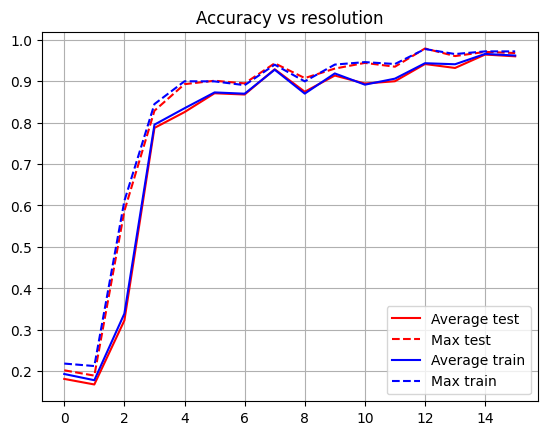

In [13]:
average_test=np.average(scores_test,axis=1)
max_test=np.max(scores_test,axis=1)
average_train=np.average(scores_train,axis=1)
max_train=np.max(scores_train,axis=1)

plt.plot(average_test,c="r",label="Average test")
plt.plot(max_test,"--",c="r",label="Max test")

plt.plot(average_train,c="b",label="Average train")
plt.plot(max_train,"--",c="b",label="Max train")
plt.title("Accuracy vs resolution")
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig(path+"/images/NM_resolution.pdf")
plt.show()

### LSTM train

In [31]:
torch.cuda.empty_cache()
train_loader,test_loader,unique=genLSTMData(0,4)
model,history=runLSTM(train_loader,0,4)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/uber_lstm")

Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 25800 
Window size: 4 
Image: (110, 120)
Memory needed: 1.27 GB
Memory left 12.0 GB
Using 10.15 GB
torch.Size([25799, 4, 13200])
torch.Size([25799, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_13128\1829792294.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [516/516], Loss: 1289.4613
Epoch [11/100], Step [516/516], Loss: 110.1681
Epoch [21/100], Step [516/516], Loss: 19.4163
Epoch [31/100], Step [516/516], Loss: 8.1807
Epoch [41/100], Step [516/516], Loss: 4.6755
Epoch [51/100], Step [516/516], Loss: 2.9893
Epoch [61/100], Step [516/516], Loss: 2.0193
Epoch [71/100], Step [516/516], Loss: 1.5607
Epoch [81/100], Step [516/516], Loss: 1.2104
Epoch [91/100], Step [516/516], Loss: 0.9979
Finished Training
Accuracy: 99.92054417550047 %
0.9992054417550047
Accuracy: 99.99951548274876 %
0.9999951548274877


In [ ]:
#CNN
torch.cuda.empty_cache()
train_loader,test_loader,unique=genCNNLSTMData(0,4)

In [53]:
train_loader,test_loader,unique=genCNNLSTMData(0,4)
model,history=runLSTMcnn(train_loader,0,4,num_epochs=120)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/uber_lstmCNN")


Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 25800 
Window size: 4 
Image: (110, 120)
Memory needed: 1.27 GB
Memory left 12.0 GB
Using 10.15 GB
torch.Size([25799, 1, 4, 110, 120])
torch.Size([25799, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_13128\3960679742.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/120], Step [516/516], Loss: 1252.3793
Epoch [11/120], Step [516/516], Loss: 50.8115
Epoch [21/120], Step [516/516], Loss: 28.7570
Epoch [31/120], Step [516/516], Loss: 21.7160
Epoch [41/120], Step [516/516], Loss: 18.2610
Epoch [51/120], Step [516/516], Loss: 14.2798
Epoch [61/120], Step [516/516], Loss: 11.0768
Epoch [71/120], Step [516/516], Loss: 6.9041
Epoch [81/120], Step [516/516], Loss: 5.1442
Epoch [91/120], Step [516/516], Loss: 3.5459
Epoch [101/120], Step [516/516], Loss: 3.0974
Epoch [111/120], Step [516/516], Loss: 2.0778
Finished Training
Accuracy: 99.92054417550047 %
0.9992054417550047
Accuracy: 99.99951548274876 %
0.9999951548274877


In [21]:
torch.save(model.state_dict(), path+"/model/mymodel_lstm_cnn")
print(calc(model,test_loader))
print(calc(model,train_loader))

Accuracy: 98.43897561246598 %
0.9843897561246598
Accuracy: 98.73456404272756 %
0.9873456404272756


### Look at resolution

In [ ]:
resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
test_scores=np.zeros((len(resolutions),5))
train_scores=np.zeros((len(resolutions),5))
for i,res in enumerate(resolutions):
    print("RESOLUTIONS",i,"/",len(resolutions))
    for trial in range(5):
        train_loader,test_loader,unique=genData(0,4,res)
        model,history=run(train_loader,0,4)
        test_scores[i][trial]=calc(model,test_loader)
        train_scores[i][trial]=calc(model,train_loader)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/resolutions_train",train_scores)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/resolutions_test",test_scores)


In [18]:
image=next(iter(train_loader))
print(image[0][0][0].shape)

torch.Size([440, 120])


### Look at performance

In [ ]:
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=genData(0,4)
    model,history=run(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except MemoryError as e:
    try:
        del train_loader
        del test_loader
        del model
    except: 
        pass
    

In [7]:
#3d 
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=gen3DData(0,4)
    model,history=run3D(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except Exception as e:
    print(e)
    del train_loader
    del test_loader
    del model


Dataset size: 7600 
Window size: 20 
Image: (110, 120)
Memory needed: 1.87 GB
Dataset size: 22800 
Window size: 4 
Image: (110, 120)
Memory needed: 1.12 GB
NEW SIZE (7600, 4, 110, 120)
Memory left 1.93 GB
Using 1.79 GB
torch.Size([4560, 1, 4, 110, 120])
torch.Size([4560, 13])


/tmp/ipykernel_4785/3315938198.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [92/92], Loss: 234.3537
Epoch [11/100], Step [92/92], Loss: 48.3510
Epoch [21/100], Step [92/92], Loss: 23.0498
Epoch [31/100], Step [92/92], Loss: 13.9282
Epoch [41/100], Step [92/92], Loss: 10.5324
Epoch [51/100], Step [92/92], Loss: 6.9935
Epoch [61/100], Step [92/92], Loss: 5.3027
Epoch [71/100], Step [92/92], Loss: 4.5608
Epoch [81/100], Step [92/92], Loss: 3.5445
Epoch [91/100], Step [92/92], Loss: 4.2081
Finished Training
Accuracy: 98.34447977195482 %
0.9834447977195483
Accuracy: 98.37997861900716 %
0.9837997861900716


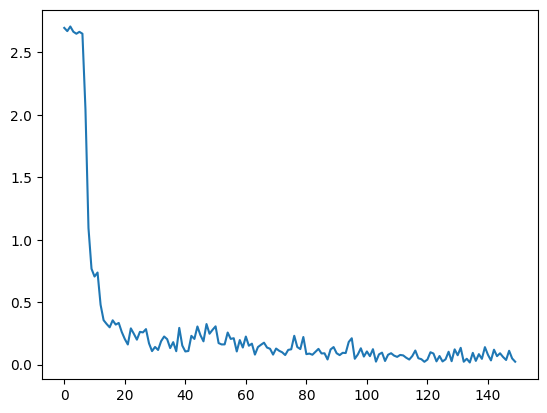

TypeError: save() missing 1 required positional argument: 'arr'

In [52]:
plt.plot(history)
plt.show()
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/ubermodellstmcnn.pdf")

(1092,) (1092,)


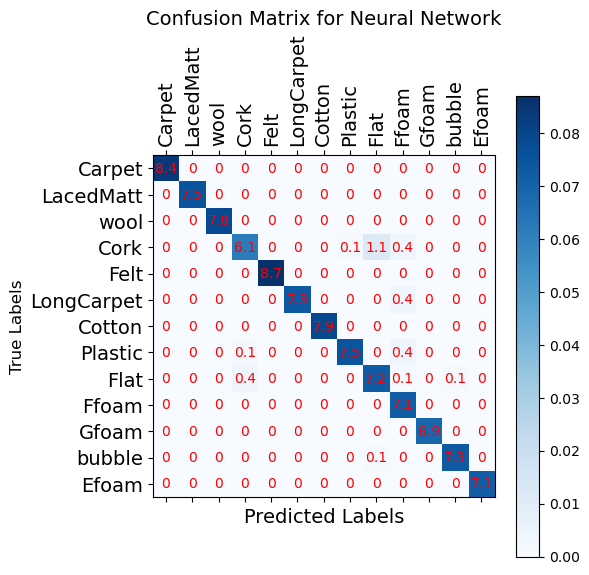

In [10]:
preds=None
real=None
keys=['Carpet', 'LacedMatt', 'wool', 'Cork', 'Felt', 'LongCarpet', 'Cotton', 'Plastic', 'Flat', 'Ffoam', 'Gfoam', 'bubble', 'Efoam', 'Jeans', 'Leather']
for i, (inputs, labels) in enumerate(test_loader):
    outputs = model(inputs)
    a=torch.argmax(outputs.detach(),axis=1)
    if type(preds)==type(None):
        preds=a.numpy().copy()
        real=np.argmax(labels.numpy().copy(),axis=1)
    else:
        preds=np.concatenate([preds,a.numpy().copy()])
        real=np.concatenate([real,np.argmax(labels.numpy().copy(),axis=1)])


def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(real)
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix/len(true_labels)

print(real.shape,preds.shape)
# Combine all predictions
predictions = [preds]
model_names = ['Neural Network']
num_classes = len(np.unique(real))
un=np.unique(real)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(6, 6))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(real, preds, num_classes=len(np.unique(real)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{round(value*100) if round(value*100,1) == 0.0 else round(value*100,1)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([keys[unique[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([keys[unique[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig(path+"/images/NM_confusionCNN.pdf")
plt.show()

In [31]:
torch.save(model.state_dict(), "C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel")


In [6]:
model = SimpleCNN(abs(0-4)*110,120,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

RuntimeError: Error(s) in loading state_dict for SimpleCNN:
	size mismatch for conv2.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([10, 32, 3, 3]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([128, 211200]) from checkpoint, the shape in current model is torch.Size([128, 33000]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([13, 128]) from checkpoint, the shape in current model is torch.Size([15, 128]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([15]).

In [15]:
#perform on unseen pressures

#load in numpy
data=np.load(datapath+"datasets/X_texture_pout.npz")
for array_name in data:
    x_unseen=(data[array_name].astype(np.uint8))
data=np.load(datapath+"datasets/y_texture_pout.npz")
for array_name in data:
    y_unseen=(data[array_name].astype(np.uint8))
print(x_unseen.shape)
#cut temporal size
x_unseen=x_unseen[:,0:4]
X=np.zeros_like(x_unseen)
#apply sobel filter
for i in range(len(x_unseen)): #crop all images individually
    for j in range(len(x_unseen[0])):
        image=x_unseen[i][j]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i][j]=sobel_combined
unique_=["Flat","wool","Efoam","LongCarpet","LacedMatt","cotton","Gfoam","Carpet","felt","Ffoam","bubble","Cork","Jeans"]
keys={'Cork': 38, 'wool': 19, 'LacedMatt': 28, 'Gfoam': 30, 'Carpet': 31, 'bubble': 37, 'Efoam': 21, 'cotton': 29, 'LongCarpet': 25, 'Flat': 16, 'felt': 34, 'Jeans': 39, 'Ffoam': 36}
        
unique_={i:keys[unique_[i]] for i in range(len(unique_))}

#concat
X=X.reshape((4,len(X)//4,1,abs(0-4)*110,120))
X=torch.tensor(X, dtype=torch.float32).to(device)
y=y_unseen.reshape(4,len(y_unseen)//4)
print(X.shape,unique_)
#run through model
predsA=torch.argmax(model(X[0]),axis=1).detach().numpy()
predsB=torch.argmax(model(X[1]),axis=1).detach().numpy()
predsC=torch.argmax(model(X[2]),axis=1).detach().numpy()
predsD=torch.argmax(model(X[3]),axis=1).detach().numpy()
data=np.array([predsA,predsB,predsC,predsD])
for i,batch in enumerate(data):
    for key in np.unique(batch):
        batch[batch==key]=unique_[key]
data=data.reshape((len(x_unseen)))
y=y.reshape((len(x_unseen)))

#show accuracy (maybe confusion matrix of sorts)
correct=0
summed=0.1
a=data==y
summed+=len(x_unseen)
correct+=len(a[a==1])
print("Accuracy:",(correct/summed)*100,"%")

(800, 20, 110, 120)
torch.Size([4, 200, 1, 440, 120]) {0: 16, 1: 19, 2: 21, 3: 25, 4: 28, 5: 29, 6: 30, 7: 31, 8: 34, 9: 36, 10: 37, 11: 38, 12: 39}
Accuracy: 99.9875015623047 %


# Vis

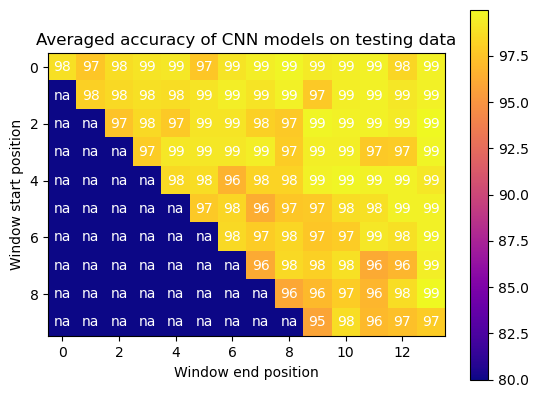

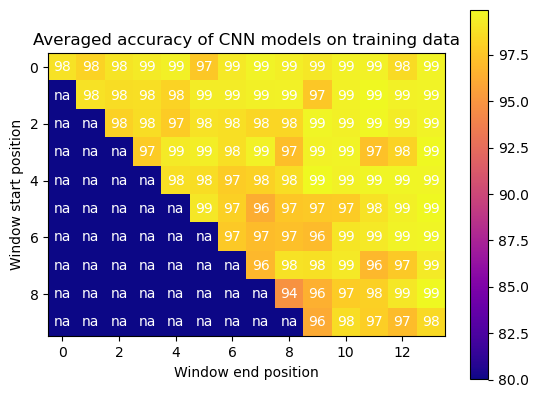

In [16]:
test=np.load(path+"saves/test_scores.npy")
train=np.load(path+"saves/train_scores.npy")

test=np.max(test,axis=2)*100
"""test=(test-np.min(test))/(np.max(test)-np.min(test))
test*=255"""
test[test==0]=80
plt.imshow(test,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        num=int(test[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')

plt.title("Averaged accuracy of CNN models on testing data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()



train=np.max(train,axis=2)*100
train[train==0]=80
plt.imshow(train,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        num=int(train[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')
plt.title("Averaged accuracy of CNN models on training data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()

## Feature layer

In [13]:
data=loaded(4,filename="X_data_newMorph.npz")
data.applySobel()
sample_of_data=data.X[0:10]

model = SimpleCNN(abs(4)*data.X.shape[2],data.X.shape[3],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel"))
model.eval()


x_data=data.X[0:4].reshape((len(data.X[0:4]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data))
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)


Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB


(110, 30)


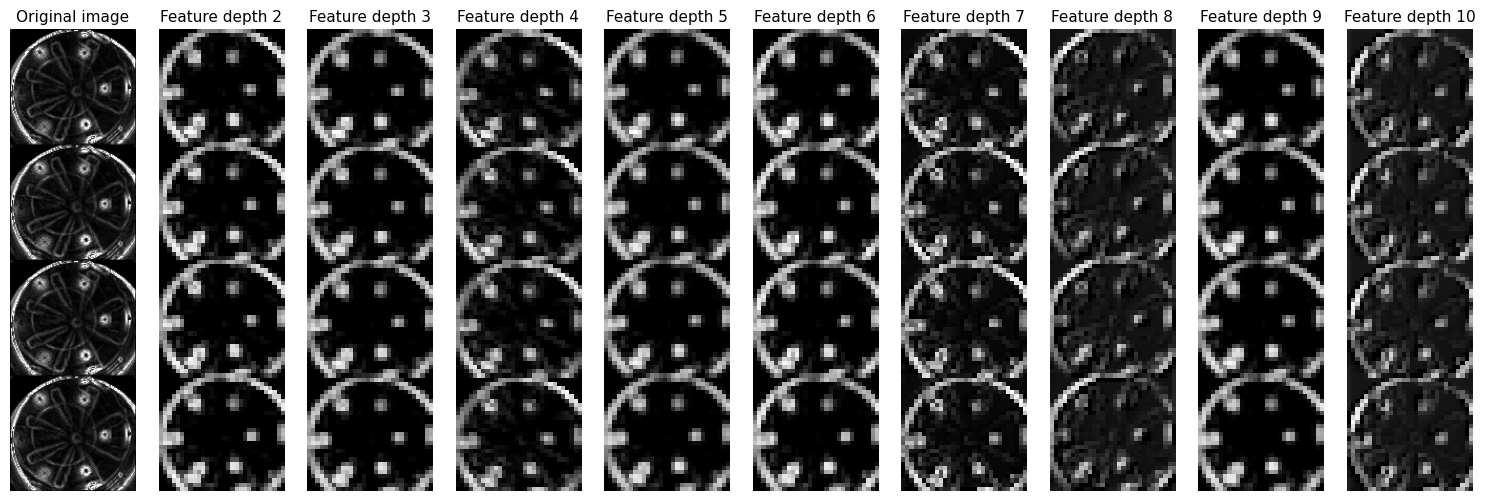

In [12]:

#forward pass
x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
print(x[0][0].shape)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
axes = axes.flatten()
axes[0].imshow(train_images_tensor[0][0].cpu().detach().numpy(),cmap="gray")
axes[0].axis("off")
axes[0].set_title("Original image",fontsize=11)
for i in range(1,10):
    axes[i].imshow(x[2][i],cmap="gray")
    axes[i].axis("off")
    axes[i].set_title("Feature depth "+str(i+1),fontsize=11)
plt.tight_layout()
plt.savefig(path+"images/featuresALL_uberModel.pdf")
plt.show()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
(9000, 52800)


/its/home/drs25/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/its/home/drs25/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


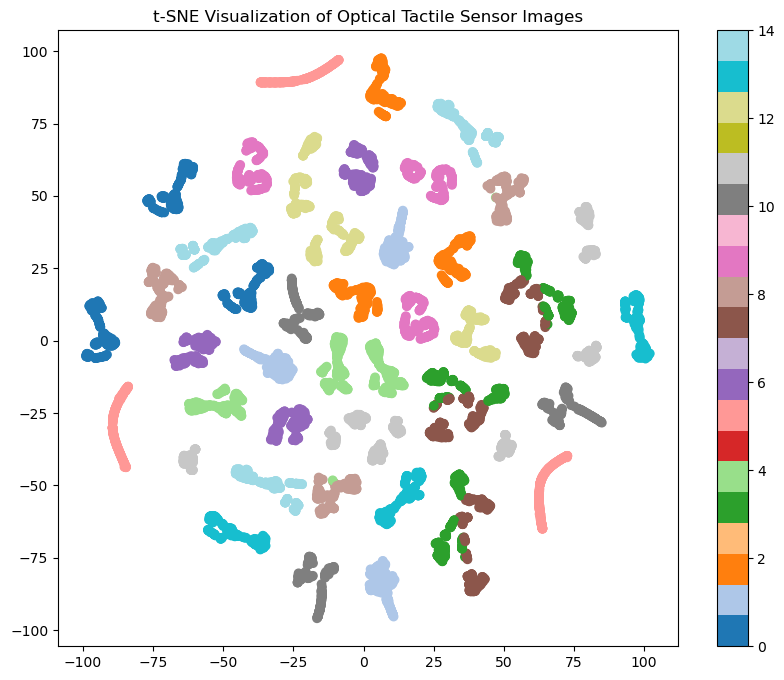

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data=loaded(t=4)
data.applySobel()
data.augment()

# Reduce dimensionality with PCA
pca = PCA(n_components=833)
x_data=data.X[0:].reshape((len(data.X[0:]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
labels=data.y[0:]
print(x_data.reshape(len(x_data), -1).shape)
pca_features = pca.fit_transform(x_data.reshape(len(x_data), -1))

# Further reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='tab20')
plt.colorbar()
plt.title('t-SNE Visualization of Optical Tactile Sensor Images')
plt.savefig(path+"/images/clusters.pdf")
plt.show()

# Point prediction

In [ ]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p
sample=data.X[0:750]
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)+140
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()

# Just points

In [47]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=5)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


(3000, 5, 110, 120)
(3000, 5, 110, 120) (3000, 5, 260, 270)


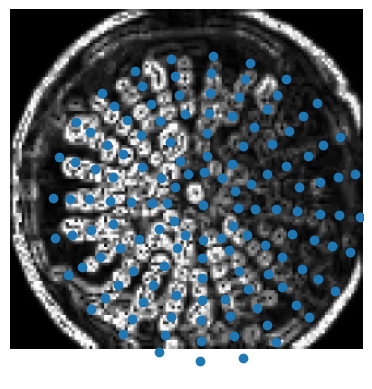

In [48]:
sample=data.X
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()
del sample
del X_prime
del X_alt

## FNN

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size):
        super(SimpleNeuralNetwork, self).__init__()
        
        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_layer1_size)
        
        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_layer1_size, hidden_layer2_size)


        self.fc3 = nn.Linear(hidden_layer2_size, 50)
        
        # Define the output fully connected layer
        self.fc4 = nn.Linear(50, output_size)
    
    def forward(self, x):
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        # Apply the output fully connected layer
        x = self.fc4(x)
        
        return x


In [99]:
X = np.round(coords.reshape((len(coords),-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
hidden_layer1_size = len(X[0]) //2  # Number of neurons in the first hidden layer
hidden_layer2_size = 800  # Number of neurons in the second hidden layer
output_size = len(un)     # Number of output features

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Print the model architecture
print(model)
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
print(X.shape,y.shape,X.dtype,y.dtype)
# Create a TensorDataset and DataLoader
#dataset = TensorDataset(torch.Tensor(train_X).to(device), torch.Tensor(train_y).to(device))
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


SimpleNeuralNetwork(
  (fc1): Linear(in_features=1330, out_features=665, bias=True)
  (fc2): Linear(in_features=665, out_features=800, bias=True)
  (fc3): Linear(in_features=800, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=15, bias=True)
)
(3000, 1330) (3000, 15) float64 float64
Epoch [1/10000], Loss: 2.7115
Epoch [101/10000], Loss: 2.7079
Epoch [201/10000], Loss: 2.7067
Epoch [301/10000], Loss: 2.7059
Epoch [401/10000], Loss: 2.7050
Epoch [501/10000], Loss: 2.7038
Epoch [601/10000], Loss: 2.7015
Epoch [701/10000], Loss: 2.6968
Epoch [801/10000], Loss: 2.6842
Epoch [901/10000], Loss: 2.6351
Epoch [1001/10000], Loss: 2.7024
Epoch [1101/10000], Loss: 2.7108
Epoch [1201/10000], Loss: 2.5478
Epoch [1301/10000], Loss: 2.5203
Epoch [1401/10000], Loss: 2.8193
Epoch [1501/10000], Loss: 2.4334
Epoch [1601/10000], Loss: 2.5988
Epoch [1701/10000], Loss: 2.4162
Epoch [1801/10000], Loss: 2.4402
Epoch [1901/10000], Loss: 2.6450
Epoch [2001/10000], Loss: 2.6623
Epoch [210

In [100]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
39.666666666666664 %
(600, 15) (2400, 15)
42.375 %


In [16]:
coords.reshape((len(coords),-1)).shape

(3000, 1064)

## LSTM

In [15]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class SimpleLSTMDrop(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(SimpleLSTMDrop, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [102]:
X = np.round(coords.reshape((len(coords),5,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 100, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 5, 266) (3000, 15) float64 (2400, 5, 266)
Epoch [100/10000], Loss: 0.0622
Epoch [200/10000], Loss: 0.0608
Epoch [300/10000], Loss: 0.0579
Epoch [400/10000], Loss: 0.0578
Epoch [500/10000], Loss: 0.0578
Epoch [600/10000], Loss: 0.0578
Epoch [700/10000], Loss: 0.0578
Epoch [800/10000], Loss: 0.0578
Epoch [900/10000], Loss: 0.0576
Epoch [1000/10000], Loss: 0.0560
Epoch [1100/10000], Loss: 0.0541
Epoch [1200/10000], Loss: 0.0535
Epoch [1300/10000], Loss: 0.0531
Epoch [1400/10000], Loss: 0.0509
Epoch [1500/10000], Loss: 0.0494
Epoch [1600/10000], Loss: 0.0494
Epoch [1700/10000], Loss: 0.0493
Epoch [1800/10000], Loss: 0.0493
Epoch [1900/10000], Loss: 0.0493
Epoch [2000/10000], Loss: 0.0493
Epoch [2100/10000], Loss: 0.0482
Epoch [2200/10000], Loss: 0.0470
Epoch [2300/10000], Loss: 0.0461
Epoch [2400/10000], Loss: 0.0461
Epoch [2500/10000], Loss: 0.0459
Epoch [2600/10000], Loss: 0.0458
Epoch [2700/10000], Loss: 0.0485
Epoch [2800/10000], Loss: 0.0425
Epoch [2900/10000], Loss: 0.0415
Epo

In [104]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
11.833333333333334 %
(600, 15) (2400, 15)
13.750000000000002 %


# Point velocities

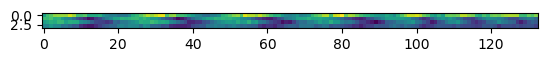

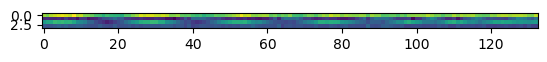

In [66]:
def plotchange(average):
    magnitudes=[]
    for t in range(len(average)-1):
        magnitudes.append(euclidean_distance(average[t],average[t+1]))
    ar=np.array(magnitudes).T
    return ar#(ar-np.min(ar))/(np.max(ar)-np.min(ar))

def euclidean_distance(point1, point2):
    # Convert points to numpy arrays
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    # Calculate the distance
    distance = np.linalg.norm(point1 - point2,axis=1)
    
    return distance

#create dataset
d1=coords[:,:-1,:]
d2=coords[:,1:,:]
distances=np.linalg.norm(d1 - d2,axis=3)



## LSTM

In [119]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1200

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 4, 133) (3000, 15) float64 (2400, 4, 133)
Epoch [10/1200], Loss: 0.0601
Epoch [20/1200], Loss: 0.0585
Epoch [30/1200], Loss: 0.0574
Epoch [40/1200], Loss: 0.0556
Epoch [50/1200], Loss: 0.0541
Epoch [60/1200], Loss: 0.0532
Epoch [70/1200], Loss: 0.0522
Epoch [80/1200], Loss: 0.0517
Epoch [90/1200], Loss: 0.0501
Epoch [100/1200], Loss: 0.0496
Epoch [110/1200], Loss: 0.0488
Epoch [120/1200], Loss: 0.0479
Epoch [130/1200], Loss: 0.0481
Epoch [140/1200], Loss: 0.0471
Epoch [150/1200], Loss: 0.0472
Epoch [160/1200], Loss: 0.0455
Epoch [170/1200], Loss: 0.0447
Epoch [180/1200], Loss: 0.0452
Epoch [190/1200], Loss: 0.0437
Epoch [200/1200], Loss: 0.0435
Epoch [210/1200], Loss: 0.0431
Epoch [220/1200], Loss: 0.0420
Epoch [230/1200], Loss: 0.0430
Epoch [240/1200], Loss: 0.0425
Epoch [250/1200], Loss: 0.0412
Epoch [260/1200], Loss: 0.0404
Epoch [270/1200], Loss: 0.0460
Epoch [280/1200], Loss: 0.0410
Epoch [290/1200], Loss: 0.0400
Epoch [300/1200], Loss: 0.0392
Epoch [310/1200], Loss: 0.0417

In [120]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
75.33333333333333 %
(600, 15) (2400, 15)
82.5 %


In [112]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTMDrop(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(3000, 4, 133) (3000, 15) float64 (2400, 4, 133)
Epoch [10/600], Loss: 0.0716
Epoch [20/600], Loss: 0.0620
Epoch [30/600], Loss: 0.0606
Epoch [40/600], Loss: 0.0597
Epoch [50/600], Loss: 0.0592
Epoch [60/600], Loss: 0.0587
Epoch [70/600], Loss: 0.0582
Epoch [80/600], Loss: 0.0576
Epoch [90/600], Loss: 0.0574
Epoch [100/600], Loss: 0.0562
Epoch [110/600], Loss: 0.0555
Epoch [120/600], Loss: 0.0546
Epoch [130/600], Loss: 0.0534
Epoch [140/600], Loss: 0.0525
Epoch [150/600], Loss: 0.0513
Epoch [160/600], Loss: 0.0504
Epoch [170/600], Loss: 0.0494
Epoch [180/600], Loss: 0.0478
Epoch [190/600], Loss: 0.0465
Epoch [200/600], Loss: 0.0457
Epoch [210/600], Loss: 0.0452
Epoch [220/600], Loss: 0.0442
Epoch [230/600], Loss: 0.0426
Epoch [240/600], Loss: 0.0416
Epoch [250/600], Loss: 0.0405
Epoch [260/600], Loss: 0.0418
Epoch [270/600], Loss: 0.0404
Epoch [280/600], Loss: 0.0395
Epoch [290/600], Loss: 0.0403
Epoch [300/600], Loss: 0.0369
Epoch [310/600], Loss: 0.0356
Epoch [320/600], Loss: 0.0375


## FNN

In [91]:
X = distances.reshape((len(distances),-1))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 532) (3000, 15) float64 (2400, 532)
Epoch [1/10000], Loss: 2.7142
Epoch [101/10000], Loss: 2.7056
Epoch [201/10000], Loss: 2.6937
Epoch [301/10000], Loss: 2.6629
Epoch [401/10000], Loss: 2.6000
Epoch [501/10000], Loss: 2.5020
Epoch [601/10000], Loss: 2.3986
Epoch [701/10000], Loss: 2.3170
Epoch [801/10000], Loss: 2.2641
Epoch [901/10000], Loss: 2.2318
Epoch [1001/10000], Loss: 2.2112
Epoch [1101/10000], Loss: 2.1969
Epoch [1201/10000], Loss: 2.1857
Epoch [1301/10000], Loss: 2.1760
Epoch [1401/10000], Loss: 2.1672
Epoch [1501/10000], Loss: 2.1587
Epoch [1601/10000], Loss: 2.1503
Epoch [1701/10000], Loss: 2.1420
Epoch [1801/10000], Loss: 2.1339
Epoch [1901/10000], Loss: 2.1257
Epoch [2001/10000], Loss: 2.1174
Epoch [2101/10000], Loss: 2.1090
Epoch [2201/10000], Loss: 2.1007
Epoch [2301/10000], Loss: 2.0924
Epoch [2401/10000], Loss: 2.0843
Epoch [2501/10000], Loss: 2.0761
Epoch [2601/10000], Loss: 2.0679
Epoch [2701/10000], Loss: 2.0596
Epoch [2801/10000], Loss: 2.0512
Epoch [2901/

In [92]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
34.833333333333336 %
(600, 15) (2400, 15)
35.833333333333336 %


## CNN

In [109]:
X = np.round(distances.reshape((len(distances),1,4,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleCNN(len(distances[0]),len(distances[0][0]))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 1, 4, 133) (3000, 15) float64 (2400, 1, 4, 133)
Epoch [10/10000], Loss: 0.0705
Epoch [20/10000], Loss: 0.0701
Epoch [30/10000], Loss: 0.0697
Epoch [40/10000], Loss: 0.0694
Epoch [50/10000], Loss: 0.0690
Epoch [60/10000], Loss: 0.0687
Epoch [70/10000], Loss: 0.0684
Epoch [80/10000], Loss: 0.0681
Epoch [90/10000], Loss: 0.0679
Epoch [100/10000], Loss: 0.0676
Epoch [110/10000], Loss: 0.0674
Epoch [120/10000], Loss: 0.0672
Epoch [130/10000], Loss: 0.0669
Epoch [140/10000], Loss: 0.0667
Epoch [150/10000], Loss: 0.0665
Epoch [160/10000], Loss: 0.0663
Epoch [170/10000], Loss: 0.0662
Epoch [180/10000], Loss: 0.0660
Epoch [190/10000], Loss: 0.0658
Epoch [200/10000], Loss: 0.0657
Epoch [210/10000], Loss: 0.0655
Epoch [220/10000], Loss: 0.0654
Epoch [230/10000], Loss: 0.0652
Epoch [240/10000], Loss: 0.0651
Epoch [250/10000], Loss: 0.0650
Epoch [260/10000], Loss: 0.0649
Epoch [270/10000], Loss: 0.0647
Epoch [280/10000], Loss: 0.0646
Epoch [290/10000], Loss: 0.0645
Epoch [300/10000], Loss: 0

In [111]:
inputs=torch.Tensor(test_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
14.666666666666666 %
(600, 15) (2400, 15)
16.416666666666664 %


In [107]:
np.save(path+"/data/distances",distances)
np.save(path+"/data/distancesy",data.y)

# Transferability of normal model 

In [10]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodelgel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()
            

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 1.93 GB
Using 2.48 GB
torch.Size([6300, 1, 440, 120])
torch.Size([6300, 15])


/tmp/ipykernel_64935/3189561383.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 328.2897
Epoch [11/100], Step [126/126], Loss: 21.4137
Epoch [21/100], Step [126/126], Loss: 3.7549
Epoch [31/100], Step [126/126], Loss: 0.9399
Epoch [41/100], Step [126/126], Loss: 0.2917
Epoch [51/100], Step [126/126], Loss: 0.1769
Epoch [61/100], Step [126/126], Loss: 0.1354
Epoch [71/100], Step [126/126], Loss: 0.1023
Epoch [81/100], Step [126/126], Loss: 0.0839
Epoch [91/100], Step [126/126], Loss: 0.0684
Finished Training


RuntimeError: Parent directory /model does not exist.

In [11]:

modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [22]:
print(calc(model,test_loader))
print(calc(model,train_loader))

import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p

Accuracy: 99.83334655979685 %
0.9983334655979685
Accuracy: 99.99801591238268 %
0.9999801591238269
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [13]:
sample=data.X[0:300]
X_prime=np.zeros((len(sample),sample.shape[1],*data.X[0][0].shape),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2)).astype(np.uint16)
divh=X_prime[0][0].shape[0]/270
divw=X_prime[0][0].shape[1]/260
print(divh,divw,X_prime[0][0].shape)
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        temp=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=np.round(predict(reg,temp)[0])
        #X_prime[i][j]*=0 
        for point in zip(coords[i][j][:,0],coords[i][j][:,1]):
            p1=int(point[0]*divh)
            p2=int(point[1]*divw)
            cv2.circle(X_prime[i][j],(p1,p2),1,(255),2)
del sample

0.4074074074074074 0.46153846153846156 (110, 120)


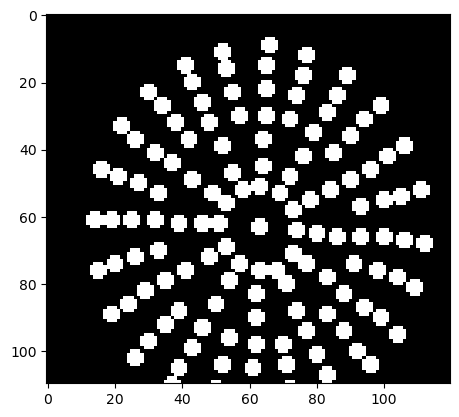

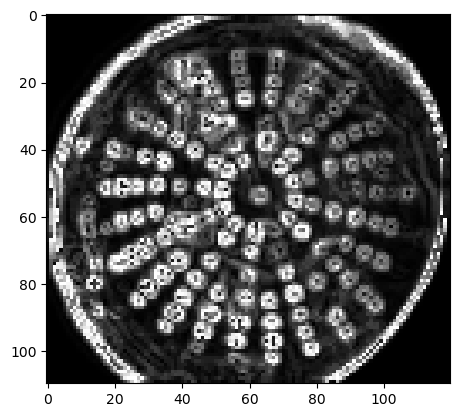

In [190]:
plt.imshow(X_prime[0][0],cmap="gray")
plt.show()
plt.imshow(data.X[0][0],cmap="gray")
plt.show()

In [49]:
x=(X_prime-np.mean(X_prime))/(np.max(X_prime)-np.min(X_prime))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
print(x.shape)
test=torch.tensor(x, dtype=torch.float32)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")


(300, 1, 440, 120)
torch.float32
6.0 %


## Taking out segments



In [ ]:
data=loaded(4,filename="X_data_newMorph.npz")
data.applySobel()

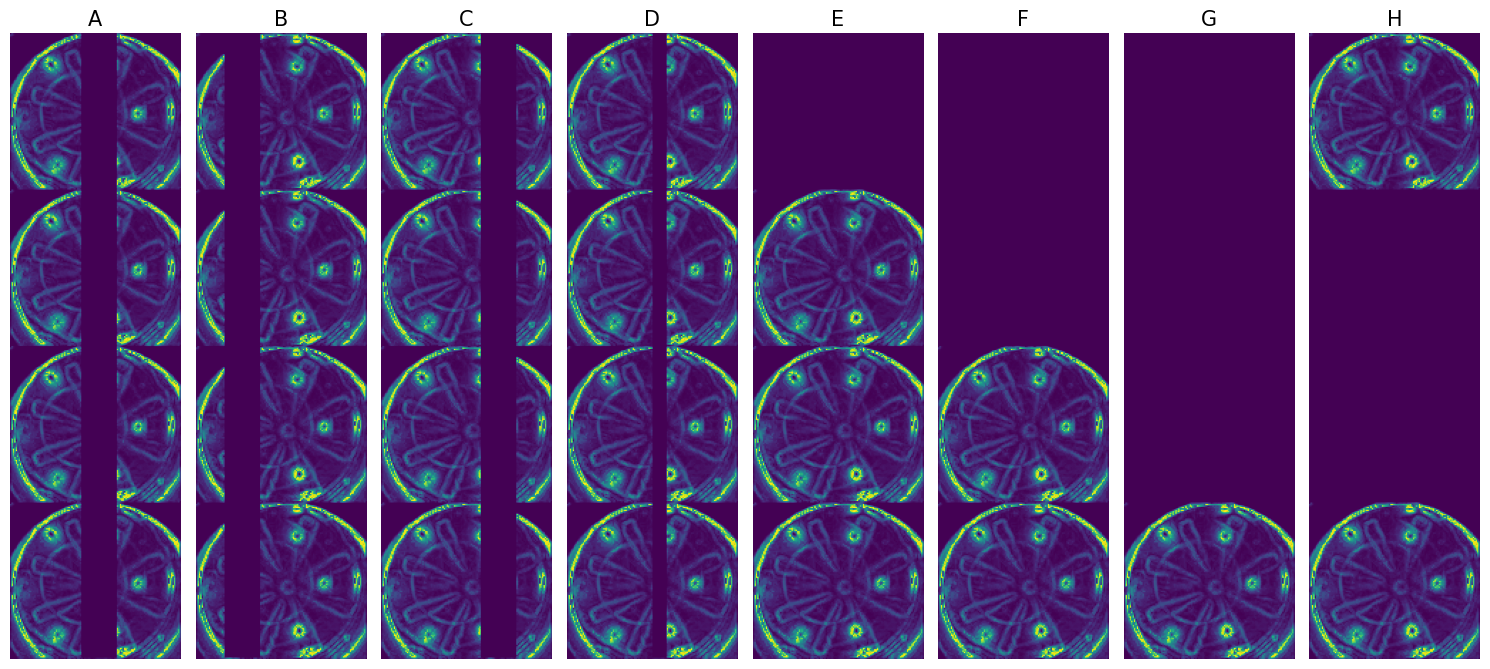

In [26]:

sample=data.X[0:300].reshape((300,1,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()
images=[sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy()]
images[0][0:-1,50:75]=0
images[1][0:-1,20:45]=0
images[2][0:-1,70:95]=0
images[3][0:-1,60:70]=0
images[4][0:110,0:120]=0
images[5][0:220,0:120]=0
images[6][0:330,0:120]=0
images[7][110:330,0:120]=0
label=["50:75","20:45","70:95","60:70","Segment removed","Two removed","Three removed","Only first and last"]
label=["A","B","C","D","E","F","G","H"]
sample[:,:,0:-1,50:75]=0

fig, axes = plt.subplots(1, len(images), figsize=(15,8))
axes = axes.flatten()
for i in range(len(images)):
    axes[i].set_title(label[i],fontsize=15)
    axes[i].imshow(images[i])
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(path+"/images/samplesCrops_newMorph.pdf")
plt.show()


In [10]:

model=SimpleCNN(data.X.shape[2]*4,data.X.shape[3],13).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph_best"))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
  (relu): ReLU()
)

In [27]:
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
print(x.shape)
test=torch.tensor(x, dtype=torch.float32)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")

#None = 100%
#A = 52% 50:75
#B = 67% 20:45
#C = 79% 70:95
#D = 96% 60:70
#E = 94% first segment removed
#F = 64% first two removed
#G = 32% first three removed
#H = 83% only first and last

(300, 1, 440, 120)
torch.float32
54.666666666666664 %


# Different pressures

In [ ]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodel_withLowPressure") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
print(calc(model,test_loader))
print(calc(model,train_loader))

In [6]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model=SimpleLSTM(image.shape[0],1000,15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodel_lstm"))
model.eval()
#print(calc(model,test_loader))
#print(calc(model,train_loader))

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [54]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
d.applySobel()
sample=d.X
label=d.y


Dataset size: 800 
Window size: 20 
Image: (110, 120)
Memory needed: 0.2 GB


In [55]:
sample=d.X
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1],x.shape[2],x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds[preds==11]
print(len(a)/len(preds) *100,"%")
del test
del x

93.875 %


In [56]:
p20=d.X[np.where(d.y==3)]
p30=d.X[np.where(d.y==0)]
p40=d.X[np.where(d.y==2)]
p50=d.X[np.where(d.y==1)]
data=[p20,p30,p40,p50]
accs=[]
for i in range(4):
    sample=data[i]
    label=11
    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1],x.shape[2],x.shape[3]))  #n,1,t*h,w for cnn, n,t,h*w for lstm, n,1,t,h,w for cnn-lstm
    test=torch.tensor(x, dtype=torch.float32).to(device)
    preds=model(test)
    preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
    a=len(preds[preds==label])
    print(a/len(preds) *100,"%")

78.5 %
98.5 %
100.0 %
99.5 %
